In [4]:
import pandas as pd
from matplotlib import pyplot as plt
# from ..ds.tensorboard import TensorboardExperiment
from PIL import Image
import os
import datetime
import math

In [1]:
%load_ext tensorboard
%reload_ext tensorboard

%tensorboard --logdir ../runs

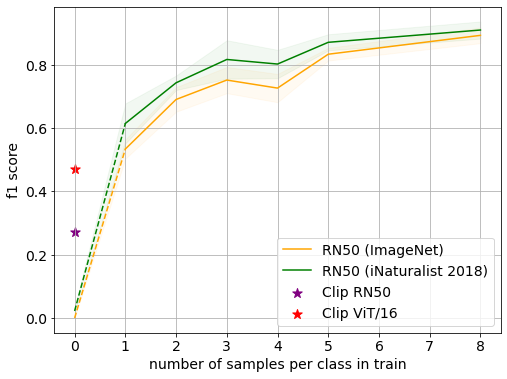

In [29]:
import matplotlib
name = 'hparams_table_max_k=8_imagenet_inat.csv'

matplotlib.rcParams.update({'font.size': 14})

metric = 'f1_score'
hparams_full = pd.read_csv(name)
stages = ['no_pretrain', 'check_full_pretrain']
# stages = hparams_full['stage'].unique()
results_full = pd.DataFrame()
for stage in stages:
    hparams_stage = hparams_full[hparams_full['stage'] == stage]
    results = pd.DataFrame({'k': hparams_stage['k'].unique()})
    results['stage'] = stage
    dict_mean_metric = hparams_stage.groupby('k')[f'test_{metric}'].mean().to_dict()
    dict_std_metric = hparams_stage.groupby('k')[f'test_{metric}'].std().to_dict()
    results[f'mean_{metric}'] = results['k'].map(dict_mean_metric)
    results[f'std_{metric}'] = results['k'].map(dict_std_metric)
    results.to_csv(f'{stage}.csv')
    results_full = pd.concat([results_full, results])
max_k = results_full['k'].max()
name_time = datetime.datetime.now().strftime('%d%h_%I_%M')
# tracker = TensorboardExperiment(log_path=f'{log_dir}/metrics/{metric}/max_k={max_k}/{name_time}')
fig = plt.figure(figsize=(8, 6))
colors = ['orange', 'green']
labels = {'no_pretrain': 'RN50 (ImageNet)', 'check_full_pretrain': 'RN50 (iNaturalist 2018)'}
for stage, color in zip(stages, colors):
    results = results_full[results_full['stage'] == stage]
    plt.plot(results[results['k'] < 2]['k'], results[results['k'] < 2][f'mean_{metric}'], color=color, linestyle='--')
    plt.plot(results[results['k'] > 0]['k'], results[results['k'] > 0][f'mean_{metric}'], color=color, label=f'{labels[stage]}')
    plt.fill_between(results['k'], (results[f'mean_{metric}'] - results[f'std_{metric}']),
                     (results[f'mean_{metric}'] + results[f'std_{metric}']), color = color, alpha=0.05)
#     plt.title(f'Mean {metric}')
colors = ['purple', 'red']
labels = ['Clip RN50', 'Clip ViT/16']
zero_shot_f1_scores = {'Clip RN50': 0.27, 'Clip ViT/16': 0.47}
for label, color in zip(labels, colors):
    plt.scatter(0, zero_shot_f1_scores[label], color=color, label=label, marker='*', s=100)
plt.xlabel('number of samples per class in train')
plt.ylabel('f1 score')
plt.grid()
plt.legend()
# tracker.add_figure(f'{metric.upper()}', fig)
# tracker.flush()
plt.show()